# Training spiking neural networks, *fast*

Spiking neural networks (SNN) can be notoriously slow to train. A special case of recurrent neural network, they work with sequential inputs and rely on a form of gradient computation through time, which in the most common scenario is backpropagation through time. Given that events from event cameras or silicon cochlears have a temporal resolution of down to microseconds, the amount of time steps per sample can easily become the largest dimension in the input sample. 

This would not be a problem if we trained on the extremely sparse data in continuous time directly, but the legacy of ANN machine learning frameworks has it that we have to work with dense tensors to train our SNN. That means that for a visual event stream input (think video) of spatial size (2, 128, 128) for channels, y and x we not only deal with some 10 frames per second but potentially hundreds per second, which increases input dimensions by a lot. 

When training a neural network of any kind, one might think about how the learning rate or model size affect training time. But when it comes to training *faster*, optimizing data movement is crucial. 3 out of the first 4 points in [this list](https://www.reddit.com/r/MachineLearning/comments/kvs1ex/d_here_are_17_ways_of_making_pytorch_training/) weighted after potential speed-up have to do with how data is shaped and moved around between actual computations. It makes a huge difference, because training faster with the same hardware means getting results faster, and being able to iterate quicker.

For this post we train an SNN using [Sinabs](https://github.com/synsense/sinabs) based on PyTorch and surrogate gradients, which means that in the forward pass we use the heavily quantized output of spiking layers but in the backward pass we use a smoother surrogate function based on the internal state of the neurons. We'll use the [Heidelberg Spiking Speech Commands](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset to train our network to do audio stream classification. We'll benchmark different data loading strategies using [Tonic](https://github.com/neuromorphs/tonic) and show that with the right strategy, we can achieve a speed-up of up to XX times compared to the naïve approach.

For all our benchmarks, we already assume multiple worker loading threads and pinning the GPU memory. We'll increase throughput by using different forms of caching to disk or GPU. By applying deterministic transformations upfront and saving the new tensor, we can save a lot of time during training. 
This tutorial is run on a machine with Ubuntu 20.04, an Intel Core i7-8700K CPU @ 3.70GHz, a Samsung SSD 850 and a NVIDIA GeForce RTX 2070 GPU.

All data from neuromorphic datasets in Tonic is provided as NxD numpy arrays. We'll need to transform this into a dense tensor to bring it to the GPU, and we'll also do some downsampling of time steps. Let's first define the transform. We know that the input data has 700 channels and about 0.8-1.2s samples with microsecond resolution. We'll downsample each sample to 100 channels, bin every 4 ms to one frame and cut samples that are longer than 1s. That leaves us with a maximum of 250 time steps per sample.


<!-- Accelerators such as TPUs, Cerebra and the like heavily -->

In [1]:
from tonic import transforms

dt = 4000  # all time units in Tonic in us
encoding_dim = 100

dense_transform = transforms.Compose(
    [
        transforms.Downsample(spatial_factor=encoding_dim / 700),
        transforms.CropTime(max=1e6),
        transforms.ToFrame(
            sensor_size=(encoding_dim, 1, 1), time_window=dt, include_incomplete=True
        ),
    ]
)

Next we'll import the training dataset and assign the transform.

In [2]:
import torch
import tonic

dense_dataset = tonic.datasets.SSC("./data", split="train", transform=dense_transform)
print(f"This dataset has {len(dense_dataset)} samples.")

This dataset has 75466 samples.


Let's also plot one such dense tensor:

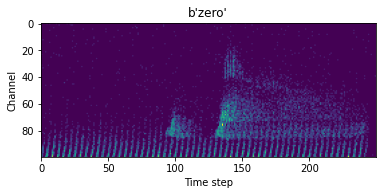

In [3]:
dense_sample, dense_target = dense_dataset[0]

import matplotlib.pyplot as plt

plt.imshow(dense_sample.squeeze().T)
plt.xlabel("Time step")
plt.ylabel("Channel")
plt.title(dense_dataset.classes[dense_target]);

Before we start the benchmarks, let's also define a spiking model. For each dataloading method, we're also going to test two different models. One is a Sinabs model which is pure PyTorch and the second one is an [EXODUS](https://arxiv.org/abs/2205.10242) model. Both models compute the same activations and gradients, but the latter vectorizes gradient computation across the time dimension using custom CUDA code, which results in a significant speedup.

In [4]:
import torch.nn as nn
import sinabs.layers as sl
import sinabs.exodus.layers as el


class SNN(nn.Sequential):
    def __init__(self, backend, hidden_dim: int = 128):
        assert backend == sl or backend == el
        super().__init__(
            nn.Linear(encoding_dim, hidden_dim),
            backend.IAF(),
            nn.Linear(hidden_dim, hidden_dim),
            backend.IAF(),
            nn.Linear(hidden_dim, hidden_dim),
            backend.IAF(),
            nn.Linear(hidden_dim, 35),
        )


sinabs_model = SNN(backend=sl).cuda()
exodus_model = SNN(backend=el).cuda()

## 1. Naïve dataloading

We start with the first benchmark, where we load every sample from an hdf5 file on disk which provides us with a numpy array in memory. For each sample, we apply the [ToFrame](https://tonic.readthedocs.io/en/main/reference/generated/tonic.transforms.ToFrame.html) transform (defined earlier) to create a dense array which we can then batch together with other samples and feed it to the network.

![naive caching](images/caching1.png "Naive caching")


In [5]:
import tonic
from tqdm import tqdm
from torch.utils.data import DataLoader

dataloader_kwargs = dict(
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=4,
)

naive_dataloader = DataLoader(dense_dataset, **dataloader_kwargs)

In [6]:
import sinabs

n_repetitions = 1
sinabs_results = []
exodus_results = []


def training_loop(dataloader, model):
    for data, targets in tqdm(dataloader):
        data, targets = data.squeeze().cuda(), targets.cuda()
        sinabs.reset_states(model)
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output.sum(1), targets)
        loss.backward()


import timeit

In [7]:
sinabs_results.append(
    timeit.timeit(
        lambda: training_loop(naive_dataloader, sinabs_model), number=n_repetitions
    )
)
exodus_results.append(
    timeit.timeit(
        lambda: training_loop(naive_dataloader, exodus_model), number=n_repetitions
    )
)

100%|██████████| 589/589 [01:47<00:00,  5.48it/s]


That's about 6-7 iterations/s, which is not very exciting. We haven't even started training yet! 

## Disk caching
Let's try to be a bit smarter now. ToFrame is a deterministic transform, so for the same sample we'll always receive the same transformed data. Given that we might train for 100 epochs, which looks at each sample 100 times, that's a lot of wasted compute! Now we're going to cache, which means save, those transformed sampled to disk during the first epoch, so that we don't need to recompute them!

![Disk caching](images/caching2.png "Disk caching")

In [8]:
disk_cached_dataset = tonic.DiskCachedDataset(
    dataset=dense_dataset,
    cache_path=f"cache/{dense_dataset.__class__.__name__}/train/{encoding_dim}/{dt}",
)

disk_cached_dataloader = DataLoader(disk_cached_dataset, **dataloader_kwargs)

In [9]:
training_loop(disk_cached_dataloader, exodus_model)

100%|██████████| 589/589 [03:09<00:00,  3.10it/s]


189.88274224381894

This is slower than the Sinabs run before, what happened? In the first epoch, the caching will likely slow down the training. But let's see what happens in the second epoch.

In [10]:
sinabs_results.append(
    timeit.timeit(
        lambda: training_loop(disk_cached_dataloader, sinabs_model),
        number=n_repetitions,
    )
)
exodus_results.append(
    timeit.timeit(
        lambda: training_loop(disk_cached_dataloader, exodus_model),
        number=n_repetitions,
    )
)

100%|██████████| 589/589 [00:19<00:00, 30.66it/s]


32 iterations/s? Now this is faster! Every epoch from now on will load data at this speed, at the expense of disk space. How much disk space does it cost you may ask? Let's compare the size of the original dataset and the cache folder...

In [11]:
from pathlib import Path

size_orig_dataset = (
    sum(f.stat().st_size for f in Path("data").glob("**/*.h5") if f.is_file()) / 1e9
)
size_cache_folder = (
    sum(f.stat().st_size for f in Path("cache").glob("**/*") if f.is_file()) / 1e9
)

print(
    f"The size of the original dataset file is {round(size_orig_dataset, 2)} GB compared to the generated cache folder with {round(size_cache_folder, 2)} GB."
)

The size of the original dataset file is 2.65 GB compared to the generated cache folder with 1.04 GB.


This is quite efficient. As a reminder, the original dataset in this case contained numpy events, whereas the cache folder contains dense tensors. We can compress the dense tensors that much because by default Tonic uses lightweight compression during caching. Disk caching is a generally applicable and will save you a lot of time in the long run.

## GPU caching
We can even go faster! Instead of loading dense tensors from disk, we can try to cram all our dataset onto the GPU! Now, the issue is that with dense tensors this wouldn't work as they would occupy too much memory. But events are already an efficient format right? So we'll store the events on the GPU as sparse tensors and then simply inflate them by calling to_dense() for each sample. This method is obviously bound by GPU memory so works with rather small datasets such as then one we're testing. However, once you're setup, you can train with _blazing_ speed. Let's have a look!

![Disk caching](images/caching3.png "Disk caching")

In [12]:
data_list = []
target_list = []
for data, targets in tqdm(disk_cached_dataloader):
    data_list.extend(
        list(map(lambda x: x.squeeze().to_sparse().coalesce().cuda(), data))
    )
    target_list.extend(list(map(lambda x: x.byte().cuda(), targets)))

sparse_tensor_dataset = list(zip(data_list, target_list))

# Samples that are already on the GPU can only be retrieved in a single thread currently
dataloader_kwargs.pop("num_workers")
dataloader_kwargs.pop("pin_memory")
sparse_tensor_dataloader = DataLoader(
    sparse_tensor_dataset, **dataloader_kwargs, num_workers=0
)

100%|██████████| 589/589 [00:23<00:00, 24.58it/s]


In [13]:
def gpu_training_loop(model):
    for data, targets in tqdm(sparse_tensor_dataloader):
        data = data.to_dense()
        sinabs.reset_states(model)
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output.sum(1), targets)
        loss.backward()

In [14]:
sinabs_results.append(
    timeit.timeit(lambda: gpu_training_loop(sinabs_model), number=n_repetitions)
)

100%|██████████| 589/589 [03:11<00:00,  3.08it/s]


In [15]:
exodus_results.append(
    timeit.timeit(lambda: gpu_training_loop(exodus_model), number=n_repetitions)
)

100%|██████████| 589/589 [00:16<00:00, 35.35it/s]


The last line returns instantly... 10k batches/s sound like something we'd like to work with. The dataset now occupies some 8-9GB of GPU memory, which is quite a lot for a dataset of this size. But the speed speaks for itself, so it might pay off to run your experiments on an earlier-generation GPU with more memory just to really crank up that utilisation percentage!


## Fast training
So far, all we've done is loading the data on the device. It would be good to see how fast we can really train a network on the task. We'll use again our three dataloaders (naïve version, disk-cached and GPU-cached) to look at actual training times. Let's start by defining a simple integrate-and-fire (IAF) feed-forward (Sequential) architecture using [Sinabs](https://sinabs.readthedocs.io):

In [24]:
import pandas as pd

dataloading_types = ["Naïve", "Disk-cached", "GPU-cached"]
df = pd.concat(
    (
        pd.DataFrame(
            {
                "Training loop time (s)": sinabs_results,
                "Backend": "Sinabs",
                "Dataloading": dataloading_types,
            }
        ),
        pd.DataFrame(
            {
                "Training loop time (s)": exodus_results,
                "Backend": "EXODUS",
                "Dataloading": dataloading_types,
            }
        ),
    )
)

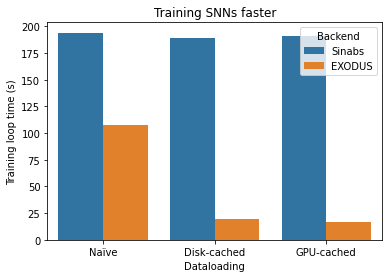

In [29]:
import seaborn as sns

sns.barplot(data=df, x="Dataloading", y="Training loop time (s)", hue="Backend").set(
    title="Training SNNs faster"
);